#Insider Trading Detection using Machine Learning



# Insider Trading Detection using Machine Learning

## Problem Statement
Insider trading involves trading of a public company’s stock by individuals with access to non-public, material information.
Detecting illegal insider trading is challenging due to the absence of explicit labels and the rarity of confirmed cases.

## Objective
To identify suspicious insider trading activities by analyzing SEC insider transaction data using machine learning-based anomaly detection techniques.

## Approach
- Data cleaning and integration
- Feature engineering based on financial and behavioral indicators
- Unsupervised anomaly detection using Isolation Forest
- Interpretation of suspicious trades


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


In [ ]:
nonderiv_df = pd.read_csv(
    '/content/lit_nonderiv_sample.csv',
    low_memory=False
)

owner_df = pd.read_csv(
    '/content/owner_sample.csv',
    low_memory=False
)

print("Non-derivative transactions:", nonderiv_df.shape)
print("Owner information:", owner_df.shape)


Non-derivative transactions: (174973, 32)
Owner information: (186328, 18)


## Dataset Overview
This section inspects the structure, data types, and missing values in the dataset.


In [ ]:
nonderiv_df.head()


,URL,accessionNumber,filingDate,filerCik,transactionType,tableRow,securityTitle,securityTitleFn,transactionDate,transactionDateFn,...,transactionAcquiredDisposedCode,transactionAcquiredDisposedCdFn,sharesOwnedFollowingTransaction,sharesOwnedFolwngTransactionFn,valueOwnedFollowingTransaction,valueOwnedFolwngTransactionFn,directOrIndirectOwnership,directOrIndirectOwnershipFn,natureOfOwnership,natureOfOwnershipFn
0,https://www.sec.gov/Archives/edgar/data/102401...,0001179110-03-007046,20030507,1024015,nonDerivativeTransaction,1,Common Stock,NaN,2003-05-05,NaN,...,A,NaN,8023,NaN,NaN,NaN,D,NaN,NaN,NaN
1,https://www.sec.gov/Archives/edgar/data/103826...,0001179110-03-007046,20030507,1038263,nonDerivativeTransaction,1,Common Stock,NaN,2003-05-05,NaN,...,A,NaN,8023,NaN,NaN,NaN,D,NaN,NaN,NaN
2,https://www.sec.gov/Archives/edgar/data/118411...,0000856223-03-000032,20030630,1184113,nonDerivativeTransaction,1,Summit Financial Corporation Common Stock,NaN,2002-10-28,NaN,...,A,NaN,86015,"F1,F2",NaN,NaN,D,NaN,NaN,NaN
3,https://www.sec.gov/Archives/edgar/data/118412...,0000856223-03-000034,20030630,1184122,nonDerivativeTransaction,1,"Common Stock, $1.00 Par Value",NaN,2002-12-30,NaN,...,A,NaN,78348,"F1,F2",NaN,NaN,D,NaN,NaN,NaN
4,https://www.sec.gov/Archives/edgar/data/118412...,0000856223-03-000033,20030630,1184121,nonDerivativeTransaction,1,"Common stock, $1.00 Par Value",NaN,2002-12-18,NaN,...,A,NaN,69397,"F1,F2,F3",NaN,NaN,D,NaN,NaN,NaN


In [ ]:
owner_df.head()


,URL,accessionNumber,filingDate,filerCik,rptOwnerCik,rptOwnerName,rptOwnerStreet1,rptOwnerStreet2,rptOwnerCity,rptOwnerState,rptOwnerZipCode,rptOwnerStateDescription,isDirector,isOfficer,isTenPercentOwner,isOther,officerTitle,otherText
0,https://www.sec.gov/Archives/edgar/data/100001...,0001233883-03-000002,20030610,1000015,0001233883,RUBIN HOWARD A,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,Executive Vice President &,NaN
1,https://www.sec.gov/Archives/edgar/data/100001...,0001233883-03-000006,20030613,1000015,0001233883,RUBIN HOWARD A,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,Executive Vice President &,NaN
2,https://www.sec.gov/Archives/edgar/data/100020...,0001181431-03-009603,20030602,1000209,0001226950,JACK JAMES E,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,EVP & Chief Financial Officer,NaN
3,https://www.sec.gov/Archives/edgar/data/100022...,0001012975-03-000139,20030602,1000228,0001003495,SHAFRAN IRVING,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN
4,https://www.sec.gov/Archives/edgar/data/100001...,0001233883-03-000004,20030611,1000015,0001233883,RUBIN HOWARD A,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,Executive Vice President &,NaN


In [ ]:
nonderiv_df = nonderiv_df[[
    'accessionNumber',
    'filerCik',
    'filingDate',
    'transactionDate',
    'transactionAcquiredDisposedCode',
    'transactionShares',
    'sharesOwnedFollowingTransaction',
    'directOrIndirectOwnership'
]]

nonderiv_df = nonderiv_df.rename(columns={
    'transactionAcquiredDisposedCode': 'buy_sell',
    'transactionShares': 'shares',
    'sharesOwnedFollowingTransaction': 'shares_after'
})

nonderiv_df['buy_sell'] = nonderiv_df['buy_sell'].map({'A': 1, 'D': 0})
nonderiv_df['transactionDate'] = pd.to_datetime(
    nonderiv_df['transactionDate'], errors='coerce'
)

nonderiv_df['shares'] = pd.to_numeric(
    nonderiv_df['shares'], errors='coerce'
)

nonderiv_df['shares_after'] = pd.to_numeric(
    nonderiv_df['shares_after'], errors='coerce'
)

nonderiv_df['direct_ownership'] = (
    nonderiv_df['directOrIndirectOwnership'] == 'D'
).astype(int)

nonderiv_df = nonderiv_df.dropna()


In [ ]:
owner_df = owner_df[[
    'accessionNumber',
    'isDirector',
    'isOfficer',
    'isTenPercentOwner',
    'officerTitle'
]].copy()

for col in ['isDirector', 'isOfficer', 'isTenPercentOwner']:
    owner_df[col] = owner_df[col].fillna(0).astype(int)

owner_df['officerTitle'] = owner_df['officerTitle'].fillna('Unknown')


## Data Integration
Transaction data is merged with reporting owner role information using the accession number.


In [ ]:
df = nonderiv_df.merge(
    owner_df,
    on='accessionNumber',
    how='left'
)

for col in ['isDirector', 'isOfficer', 'isTenPercentOwner']:
    df[col] = df[col].fillna(0).astype(int)


In [ ]:
df['is_top_insider'] = (
    (df['isDirector'] == 1) |
    (df['isOfficer'] == 1) |
    (df['isTenPercentOwner'] == 1)
).astype(int)


In [ ]:
df['filingDate_dt'] = pd.to_datetime(
    df['filingDate'].astype(str),
    format='%Y%m%d',
    errors='coerce'
)

df['transaction_gap_days'] = (
    df['filingDate_dt'] - df['transactionDate']
).dt.days

df = df[
    (df['transaction_gap_days'] >= 0) &
    (df['transaction_gap_days'] <= 180)
]


## Feature Engineering
Domain-specific behavioral features are created to enhance anomaly detection.


In [ ]:
df['trade_fraction'] = df['shares'] / (
    df['shares'] + df['shares_after'] + 1e-6
)

df['role_weight'] = (
    df['isDirector'] * 3 +
    df['isOfficer'] * 2 +
    df['isTenPercentOwner'] * 4
)


In [ ]:
features = [
    'buy_sell',
    'shares',
    'shares_after',
    'direct_ownership',
    'is_top_insider',
    'transaction_gap_days',
    'trade_fraction',
    'role_weight'
]

X = df[features]
X = StandardScaler().fit_transform(X)


## Anomaly Detection using Isolation Forest
Isolation Forest is used to detect rare and suspicious insider trading patterns.


In [ ]:
model = IsolationForest(
    n_estimators=200,
    contamination=0.01,
    random_state=42
)

df['anomaly'] = model.fit_predict(X)
df['suspicious_trade'] = (df['anomaly'] == -1).astype(int)

df['suspicious_trade'].value_counts()


,count
suspicious_trade,
0,561088
1,5658


## Interpretation of Results

The Isolation Forest model identified approximately 1% of insider trades as suspicious.
These trades typically involve:
- Top insiders such as officers, directors, or major shareholders
- Large transaction sizes relative to existing holdings
- Short time gaps between transaction execution and SEC filing

Due to the absence of labeled insider trading data, anomaly detection provides a practical and scalable solution
for identifying potentially illegal insider trading activities.


## Conclusion

This project demonstrates the application of unsupervised machine learning techniques to detect potentially suspicious
insider trading activities using SEC transaction data. By combining domain-specific feature engineering with Isolation
Forest, the model effectively highlights abnormal trading behavior that may warrant further regulatory investigation.


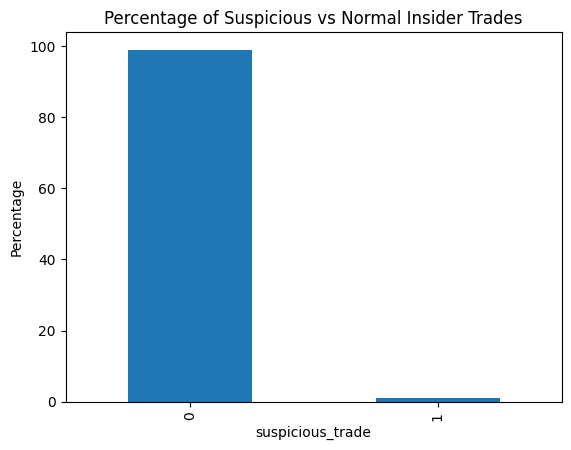

In [ ]:
(df['suspicious_trade']
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='bar'))

plt.ylabel('Percentage')
plt.title('Percentage of Suspicious vs Normal Insider Trades')
plt.show()


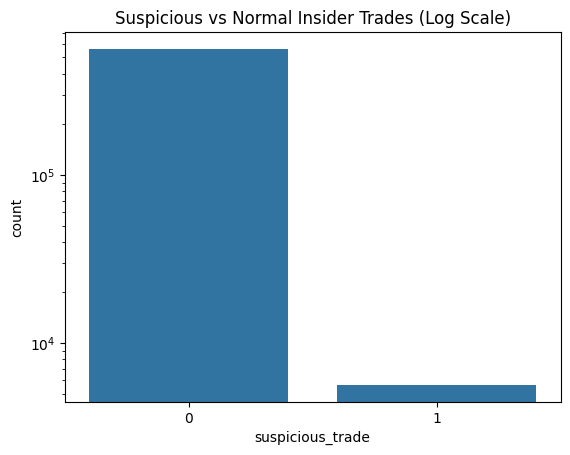

In [ ]:
sns.countplot(x='suspicious_trade', data=df)
plt.yscale('log')
plt.title('Suspicious vs Normal Insider Trades (Log Scale)')
plt.show()


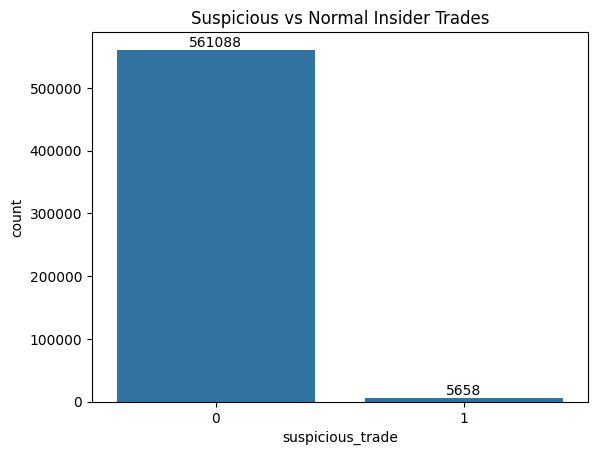

In [ ]:
ax = sns.countplot(x='suspicious_trade', data=df)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.title('Suspicious vs Normal Insider Trades')
plt.show()


In [ ]:
df[df['suspicious_trade'] == 1].to_csv(
    'suspicious_trades_output.csv',
    index=False
)


“Insider trading is a rare event. Therefore, the dataset is highly imbalanced. The anomaly detection model correctly identifies a small fraction of trades as suspicious, while the majority are classified as normal.”

#What We Have Done Till Date

This project focuses on identifying potentially suspicious insider trading activities using machine learning techniques. Since confirmed cases of illegal insider trading are extremely rare and publicly labeled datasets do not exist, the problem has been approached as an unsupervised anomaly detection task.

#1. Dataset Collection and Preparation

We used publicly available SEC insider trading data, which contains detailed records of insider transactions such as:

Filing date and transaction date

Number of shares traded

Ownership type (direct or indirect)

Insider roles (director, officer, or major shareholder)

To ensure efficient experimentation and reproducibility, a sample dataset was created from the original large dataset and uploaded directly to Google Colab, avoiding repeated downloads.

##2. Data Cleaning and Preprocessing

The raw dataset contained many irrelevant columns and missing values. To make the data suitable for machine learning, we performed the following steps:

Selected only relevant transaction and ownership-related columns

Renamed columns for clarity and consistency

Encoded transaction type:

Buy (Acquire) → 1

Sell (Dispose) → 0

Converted dates into proper datetime format

Converted numerical fields such as shares traded into numeric values

Removed records with missing or invalid values

This step ensured that the dataset was clean, consistent, and machine-learning ready.

#3. Data Integration

The insider transaction data and reporting owner data were stored in separate files.
These datasets were merged using a common key (accession number) to associate each transaction with the insider’s role.

This integration allowed us to enrich transaction records with role-based information such as:

Director

Officer

Ten-percent owner

#4. Feature Engineering

Since no direct labels for illegal insider trading exist, domain-specific features were engineered to capture suspicious trading behavior.

Key engineered features include:

Top Insider Indicator
Identifies whether a transaction was made by a director, officer, or major shareholder.

Transaction Gap (Days)
Measures the number of days between the transaction date and the filing date. Short gaps may indicate urgency or sensitive information.

Trade Fraction
Represents the proportion of shares traded relative to total holdings, highlighting unusually large trades.

Role Weight
Assigns higher importance to senior insider roles, as trades by top executives are generally more sensitive.

These features transform raw financial data into behavioral indicators suitable for anomaly detection.

#5. Feature Scaling

Before applying machine learning models, all numerical features were standardized using feature scaling.
This ensures that variables with large numeric ranges do not dominate the model and that all features contribute equally to detection.

#6. Machine Learning Model Used
Isolation Forest (Unsupervised Learning)

The core model used in this project is Isolation Forest, an unsupervised anomaly detection algorithm.

Why Isolation Forest?

Insider trading cases are rare anomalies

No labeled data is available

Isolation Forest is efficient for large datasets

It isolates abnormal points using random partitioning rather than distance measures

The model classifies:

Normal trades as 0

Suspicious trades as 1

Approximately 1% of trades were flagged as suspicious, which is realistic for fraud-related problems.

#7. Results Interpretation

The results show that:

The vast majority of insider trades are normal

A small fraction exhibits abnormal patterns such as:

Large trade sizes

Short filing delays

Trades by top insiders

These flagged trades do not confirm illegal activity but highlight transactions that warrant further investigation.

Libraries Used and Why
Pandas

Used for data loading, cleaning, merging, and manipulation of large tabular datasets.

NumPy

Used for numerical operations and efficient array handling.

Matplotlib & Seaborn

Used for data visualization and result interpretation, such as comparing normal vs suspicious trades.

Scikit-Learn

Used for:

Feature scaling (StandardScaler)

Anomaly detection (IsolationForest)

Scikit-Learn was chosen because it provides reliable, well-tested machine learning algorithms suitable for research and academic projects.

Why This Approach Is Appropriate

Insider trading data is highly imbalanced

Labeled illegal cases are unavailable

Unsupervised anomaly detection closely reflects real-world regulatory investigations

The approach is scalable, explainable, and realistic